In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print(tf.__version__)
print('GPU detected', tf.config.list_physical_devices('GPU') )

2.2.0
GPU detected []


In [4]:
from google.colab import files
uploaded = files.upload()

Saving ner_dataset.csv to ner_dataset.csv


In [0]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')

In [7]:
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [8]:
print("Unique Words in corpus", data['Word'].nunique())
print("Unique Tags in corpus", data['Tag'].nunique())

Unique Words in corpus 35178
Unique Tags in corpus 17


In [0]:
words = list(set(data['Word'].values))
words.append('WORDPAD')
num_words = len(words)

In [0]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [11]:
num_words, num_tags

(35179, 17)

In [0]:
class SentenceGetter(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data=data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
                              
    

In [0]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [14]:
sentences[10]

[('In', 'IN', 'O'),
 ('Beirut', 'NNP', 'B-geo'),
 (',', ',', 'O'),
 ('a', 'DT', 'O'),
 ('string', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('officials', 'NNS', 'O'),
 ('voiced', 'VBD', 'O'),
 ('their', 'PRP$', 'O'),
 ('anger', 'NN', 'O'),
 (',', ',', 'O'),
 ('while', 'IN', 'O'),
 ('at', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('United', 'NNP', 'B-org'),
 ('Nations', 'NNP', 'I-org'),
 ('summit', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('New', 'NNP', 'B-geo'),
 ('York', 'NNP', 'I-geo'),
 (',', ',', 'O'),
 ('Prime', 'NNP', 'B-per'),
 ('Minister', 'NNP', 'O'),
 ('Fouad', 'NNP', 'B-per'),
 ('Siniora', 'NNP', 'I-per'),
 ('said', 'VBD', 'O'),
 ('the', 'DT', 'O'),
 ('Lebanese', 'JJ', 'B-gpe'),
 ('people', 'NNS', 'O'),
 ('are', 'VBP', 'O'),
 ('resolute', 'JJ', 'O'),
 ('in', 'IN', 'O'),
 ('preventing', 'VBG', 'O'),
 ('such', 'JJ', 'O'),
 ('attempts', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('destroying', 'VBG', 'O'),
 ('their', 'PRP$', 'O'),
 ('spirit', 'NN', 'O'),
 ('.', '.', 'O')]

In [0]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
word2idx

{'shoulder-fired': 1,
 'reservists': 2,
 'classifications': 3,
 'Boss': 4,
 'Talbak': 5,
 'hunt': 6,
 'outweighs': 7,
 'obtained': 8,
 'losing': 9,
 'aiming': 10,
 'Krygyz': 11,
 'Email': 12,
 'theme': 13,
 'KFM': 14,
 'Lipsky': 15,
 'rotating': 16,
 'non-functional': 17,
 '87-store': 18,
 'Sing': 19,
 'Each': 20,
 'Bode': 21,
 'Search': 22,
 'Pangandaran': 23,
 'surprised': 24,
 'enthusiastic': 25,
 'facade': 26,
 'Jabbar': 27,
 'Dodge': 28,
 'Michele': 29,
 'Dhekelia': 30,
 'cabbage': 31,
 'bass': 32,
 'al-Sistani': 33,
 'edible': 34,
 'cruelty': 35,
 '480': 36,
 'ensemble': 37,
 'trillion': 38,
 'German-made': 39,
 'alongside': 40,
 'Tsvetana': 41,
 'plotting': 42,
 '69th': 43,
 'fabricated': 44,
 'Case-Shiller': 45,
 'towed': 46,
 'swings': 47,
 'strokes': 48,
 'all-star': 49,
 'proboscis': 50,
 'Established': 51,
 'providers': 52,
 'Discussions': 53,
 'arbitrator': 54,
 'publicist': 55,
 'Inflation': 56,
 'fruit': 57,
 'Indian-controlled': 58,
 'Certain': 59,
 'Consumers': 60,
 'R

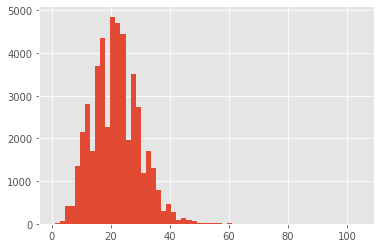

In [17]:
plt.hist([len(s) for s in sentences ], bins=60)
plt.show()

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen =max_len, sequences=X, padding='post', value=num_words-1) 

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"]) 
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=1)

In [0]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional


In [22]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length=max_len) (input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [24]:
!pip install livelossplot

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
plot_losses = PlotLossesCallback()

In [30]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience =1, verbose = 0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    X_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs = 3,
    verbose=1

) 

Epoch 1/3
1080/1080 [==============================] - 210s 194ms/step - loss: 0.1862 - accuracy: 0.9572 - val_loss: 0.0654 - val_accuracy: 0.9809
Epoch 2/3
1080/1080 [==============================] - 215s 199ms/step - loss: 0.0526 - accuracy: 0.9846 - val_loss: 0.0506 - val_accuracy: 0.9848
Epoch 3/3
1080/1080 [==============================] - 215s 199ms/step - loss: 0.0388 - accuracy: 0.9884 - val_loss: 0.0491 - val_accuracy: 0.9853


In [32]:
print('\nhistory dict:', history.history)


history dict: {'loss': [0.1862020492553711, 0.05263245850801468, 0.0387866273522377], 'accuracy': [0.9572058916091919, 0.9846029281616211, 0.9883793592453003], 'val_loss': [0.06541743874549866, 0.05058346688747406, 0.04907343164086342], 'val_accuracy': [0.9809220433235168, 0.9847608208656311, 0.985300600528717]}


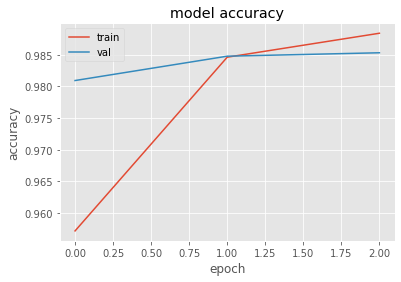

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

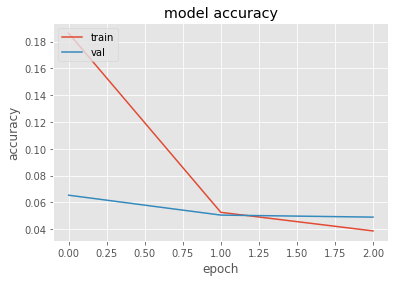

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
model.evaluate(X_test, np.array(y_test))

150/150 [==============================] - 3s 23ms/step - loss: 0.0509 - accuracy: 0.9849


[0.05092194676399231, 0.9848707318305969]

In [59]:
i = np.random.randint(0, X_test.shape[0])
p =  model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:10}\t{}\n".format("Word", "True", "Pred"))
print("-"*30)
for w,true,pred in zip(X_test[i], y_true, p[0]):
  print("{:15}{}\t".format(words[w-1], tags[true], tags[pred]))



Word           True      	Pred

------------------------------
The            O	
invasion       O	
was            O	
carried        O	
out            O	
after          O	
the            O	
fundamentalist O	
regime         O	
refused        O	
to             O	
hand           O	
over           O	
al-Qaida       B-org	
leader         O	
Osama          B-per	
bin            I-per	
Laden          I-per	
following      O	
the            O	
September      B-tim	
11th           I-tim	
terror         O	
attacks        O	
on             O	
the            O	
United         B-geo	
States         I-geo	
.              O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
exposing       O	
